In [1]:
import pandas as pd 
import numpy as np
import talib as ta

import os
import pickle

import sklearn
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder

import xgboost as xgb

import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
import sklearn.mixture as mix

import shap
import lime

from PIL import Image

import matplotlib.pyplot as plt

from math import sqrt
sqn = lambda x: round(sqrt(sum(~np.isnan(x))) * np.nanmean(x) / np.nanstd(x), 4)
open_close_change = lambda Open, Close: (Close - Open) / Open 

Using TensorFlow backend.


In [2]:
# Function for resampling OHLC data

def resample_ohlc(df, interval = '4H'):

    df_open = df.resample(interval, base = 4)['Open'].first()
    df_high = df.resample(interval, base = 4)['High'].max()
    df_low = df.resample(interval, base = 4)['Low'].min()
    df_close = df.resample(interval, base = 4)['Close'].last()
    df_volume = df.resample(interval, base = 4)['Volume'].sum()
    df = pd.concat([df_open, df_high, df_low, df_close, df_volume], axis = 1)
    
    return df.dropna()


def process_data(df, indicators = ['AOP', 'open_close_change'], n_components = 5):

    filter_indicators = [x for x in indicators] + ['open_close_change']
        
    idx = df[filter_indicators].dropna().index
    X = df[filter_indicators].dropna().values
    
    model = mix.GaussianMixture(n_components = n_components, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)
    
    hidden_states = model.predict(X)
    
    # Compose into dataframes and join together; return 
    df_hidden_states = pd.DataFrame(hidden_states, index = idx, columns = ['hidden_state'])
    return df.join(df_hidden_states, how = 'inner')
    

### Creating different datasets to test

I'd like to try the machine learning workflow using a few different test datasets... where each dataset uses a different number of indicators and GMM "components" to create the data

In [3]:
if not os.path.exists("BTCUSD_Dataset3.csv"):
    # Read local data file 
    df_data = pd.read_csv('BTCUSD.csv', error_bad_lines = False)

    # Convert time to datetime format and set as index
    df_data['Time'] = pd.to_datetime(df_data['Time'])
    df_data.set_index('Time', inplace = True)

    # Resample the data for 4-hr OHLC bars
    df_data = resample_ohlc(df_data)

    # Calculate the PnL for the candle from open to close
    df_data['open_close_change'] = df_data.apply(lambda x: open_close_change(x['Open'], x['Close']), axis = 1)

    df_data3 = df_data.copy()

    # Add the indicators to df_data3
    df_data3['MFI'] = ta.MFI(df_data['High'], df_data['Low'], df_data['Close'], df_data['Volume']).shift()
    df_data3['MOM'] = ta.MOM(df_data['Close']).shift()
    df_data3['CMO'] = ta.CMO(df_data['Close']).shift()
    df_data3['ADXR'] = ta.ADXR(df_data['High'], df_data['Low'], df_data['Close']).shift()
    k, d = ta.STOCH(df_data['High'], df_data['Low'], df_data['Close'])
    df_data3['STOCH'] = (k-d).shift()

    # Define the number of regimes the GMM model will be identifying
    n_components_data3 = 5

    # Define indicator names for the GMM function
    indicators_data3 = ['MFI', 'MOM', 'CMO', 'ADXR', 'STOCH']

    # Dataset3
    dataset3 = process_data(df_data3, indicators_data3, n_components_data3)
    filter_columns = [x for x in indicators_data3] + ['hidden_state']
    dataset3 = dataset3[filter_columns]
    
    dataset3.to_csv("BTCUSD_Dataset3.csv")
else:
    dataset3 =  pd.read_csv("BTCUSD_Dataset3.csv")
    
dataset3

Time        MFI      MOM        CMO       ADXR  \
0     2018-06-18 12:00:00  67.037297   -29.29 -12.763085  32.535069   
1     2018-06-18 16:00:00  72.715776   165.57  19.678420  32.276195   
2     2018-06-18 20:00:00  80.290928   181.23  20.604181  31.592138   
3     2018-06-19 00:00:00  71.949804   181.57  17.563845  30.876484   
4     2018-06-19 04:00:00  71.691706   186.11  19.107180  30.202404   
...                   ...        ...      ...        ...        ...   
5747  2021-02-08 16:00:00  66.604336  5824.62  52.529134  32.889374   
5748  2021-02-08 20:00:00  70.928184  7253.01  62.773698  34.561450   
5749  2021-02-09 00:00:00  76.596858  7997.22  63.151267  35.402351   
5750  2021-02-09 04:00:00  82.320259  8950.96  64.384916  35.799991   
5751  2021-02-09 08:00:00  81.364473  6745.52  37.104857  35.524336   

          STOCH  hidden_state  
0      9.337891             3  
1     13.216614             0  
2     16.624679             0  
3     10.935714             0  
4      2.401345             0  
...         ...           ...  
5747   2.735045             2  
5748  -1.941947             2  
5749   2.482697             2  
5750   0.792058             2  
5751 -10.022849             2  

[5752 rows x 7 columns]

### Machine Learning applications...

I am curious to see the various accuracies of the commonly used machine learning algorithms in predicting what the hidden states are for each of the three datasets. For example, is LSTM perhaps better than Densenet (or XGBoost, k-means, etc)?

In [4]:
from collections import Counter
print("Dataset Size : {}".format(dataset3.shape))
print("Unique Classes : {}".format(dataset3.hidden_state.unique()))
print("\nClass Distribution : ")
for cls in dataset3.hidden_state.unique():
    print("{} : {:.2f}".format(cls, dataset3.hidden_state.tolist().count(cls) / dataset3.shape[0]))
dataset3.head()

Dataset Size : (5752, 7)
Unique Classes : [3 0 1 2 4]

Class Distribution : 
3 : 0.17
0 : 0.55
1 : 0.20
2 : 0.06
4 : 0.02


Time        MFI     MOM        CMO       ADXR      STOCH  \
0  2018-06-18 12:00:00  67.037297  -29.29 -12.763085  32.535069   9.337891   
1  2018-06-18 16:00:00  72.715776  165.57  19.678420  32.276195  13.216614   
2  2018-06-18 20:00:00  80.290928  181.23  20.604181  31.592138  16.624679   
3  2018-06-19 00:00:00  71.949804  181.57  17.563845  30.876484  10.935714   
4  2018-06-19 04:00:00  71.691706  186.11  19.107180  30.202404   2.401345   

   hidden_state  
0             3  
1             0  
2             0  
3             0  
4             0

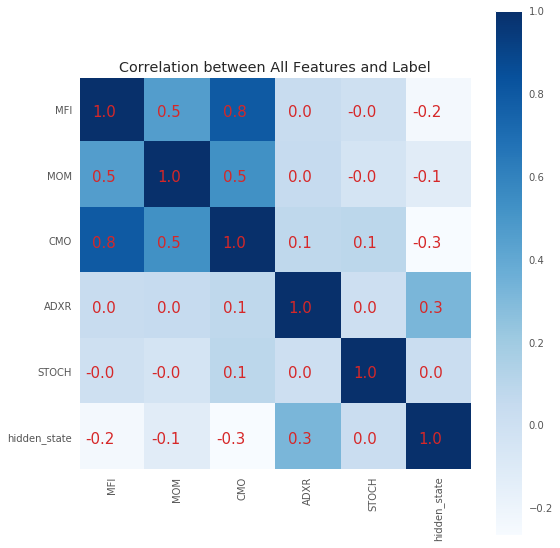

In [5]:
def plot_correlation_matrix(df, titl):
    plt.imshow(df.values, cmap=plt.cm.Blues)
    plt.xticks(range(df.shape[0]), df.columns, rotation='vertical')
    plt.yticks(range(df.shape[0]), df.columns)
    plt.title(titl)
    plt.colorbar()
    plt.grid(None)
    for i in range(0,df.shape[0]):
        for j in range(0, df.shape[0]):
            if df.values[i, j] < 0:
                plt.text(i-0.4, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=15);
            else:
                plt.text(i-0.3, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=15);
                
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(8,8))
    plot_correlation_matrix(dataset3.corr(), 'Correlation between All Features and Label')
                
    plt.tight_layout()
    
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
    
    #plt.savefig(os.path.join(batch,"correlation.png"), dpi=200)


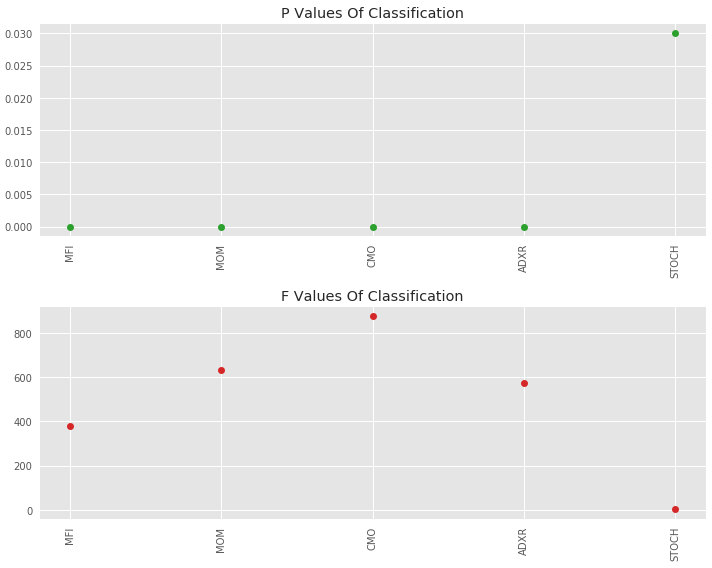

In [6]:
X = dataset3.drop(columns=["hidden_state", "Time"])
X = MinMaxScaler().fit_transform(X)
Y = dataset3['hidden_state'].values
#Y = np.array([1 if y==1 else 0 for y in Y])

cols = dataset3.drop(columns=["Time", "hidden_state"]).columns

F_classif, p_value_classif = f_classif(X, Y)

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(10,8))
    plt.subplot(211)
    plt.plot(p_value_classif, 'o', c = 'tab:green')
    plt.xticks(range(X.shape[1]), cols, rotation='vertical')
    plt.title('P Values Of Classification')
    plt.subplot(212)
    plt.plot(F_classif, 'o', c = 'tab:red')
    plt.xticks(range(X.shape[1]), cols, rotation='vertical')
    plt.title('F Values Of Classification');
    
    plt.tight_layout()
    
    #plt.savefig(os.path.join(batch,"f_p_values.png"), dpi=200)

### Hidden Set Trend

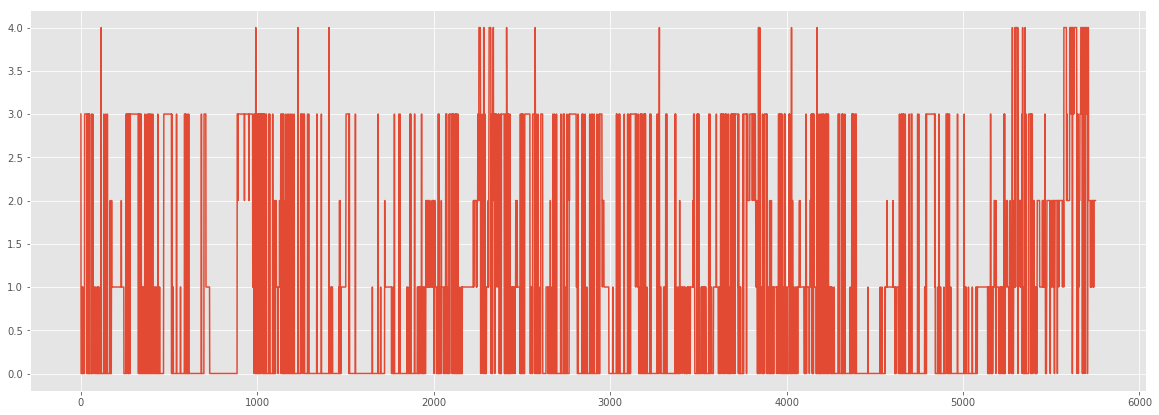

In [7]:
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(20,7))
    plt.plot(dataset3.hidden_state)

## ML/DL Algorithms

In [17]:
def plot_loss_and_accuracy(hist, prob_type='classification'):
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(hist.history['loss'], label='Train Loss')
        if "val_loss" in hist.history:
            plt.plot(hist.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        
        if prob_type=='classification':
            plt.subplot(122)
            plt.plot(hist.history['accuracy'], label='Train Accuracy')
            if "val_accuracy" in hist.history:
                plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
        elif prob_type=='regression':
            plt.subplot(122)
            plt.plot(hist.history['mse'], label='Train MSE')
            plt.plot(hist.history['val_mse'], label='Val MSE')
            plt.xlabel('Epochs')
            plt.ylabel('MSE')
            plt.legend(loc='best')
            
def print_plot_metrics(model_name, Y_test, predictions):
    print('Classification Report : \n',classification_report(Y_test, predictions))
    conf_mat = confusion_matrix(Y_test, predictions)
    print('Confusion Matrix : \n', conf_mat)
    #plot_confusion_matrix(conf_mat)
    
def plot_confusion_matrix(conf_mat):
    with plt.style.context(('seaborn', 'ggplot')):
        fig = plt.figure(figsize=(10,10))
        plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
        plt.xticks([0, 1], [-1, 1])
        plt.yticks([0, 1], [-1, 1])
        plt.grid(None)
        plt.ylabel('Actual')
        plt.xlabel('Prediction')
        plt.colorbar();
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
                

In [58]:
batch = "BTCUSD_Dataset3"

if not os.path.exists(batch):
    os.mkdir(batch)

X = dataset3.drop(columns = ["hidden_state", "Time"]).values
Y = dataset3["hidden_state"].values

print("Are there any NA in dataset? : {}".format(not np.alltrue(np.any(X))))

X.shape, Y.shape

Are there any NA in dataset? : False


((5752, 5), (5752,))

In [88]:
lookback = 3 ## Number of examples to lookback to make decision about future.

X_new, Y_new = [],[]

for i in range(X.shape[0] - lookback):
    X_new.append(X[i: i+lookback])
    Y_new.append(Y[i+lookback])
    
X_new, Y_new = np.array(X_new), np.array(Y_new)

print("Dataet Size : ",X_new.shape, Y_new.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, 
                                                    train_size=0.95, 
                                                    shuffle=False)

print("\nTrain/Test Sizes : ",X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

print("\nClass Distribution (Y_train) : ")
for cls in np.unique(Y_train):
    print("{} : {}".format(cls, Y_train.tolist().count(cls)))

print("\nClass Distribution (Y_test) : ")
for cls in np.unique(Y_test):
    print("{} : {}".format(cls, Y_test.tolist().count(cls)))

Y_train_cat, Y_test_cat = keras.utils.to_categorical(Y_train), keras.utils.to_categorical(Y_test)

Y_train_cat.shape, Y_test_cat.shape

Dataet Size :  (5749, 3, 5) (5749,)

Train/Test Sizes :  (5461, 3, 5) (288, 3, 5) (5461,) (288,)

Class Distribution (Y_train) : 
0 : 3155
1 : 1118
2 : 181
3 : 953
4 : 54

Class Distribution (Y_test) : 
0 : 18
1 : 36
2 : 138
3 : 19
4 : 77


((5461, 5), (288, 5))

## LSTM v1

In [89]:
lstm_classif_v1 = Sequential([
                        LSTM(150, input_shape=(X_train.shape[1], X_train.shape[2])),
                        Dropout(0.1),
                        Dense(Y_train_cat.shape[1], activation='softmax')                        
                        ])

print(lstm_classif_v1.summary())

#plot_model(lstm_classif_v1, to_file=os.path.join(batch, 'lstm_classif1.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'lstm_classif1.png'))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 150)               93600     
_________________________________________________________________
dropout_11 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 755       
Total params: 94,355
Trainable params: 94,355
Non-trainable params: 0
_________________________________________________________________
None


In [90]:
lstm_classif_v1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = lstm_classif_v1.fit(X_train, Y_train_cat, epochs=100, batch_size=16, verbose=2, shuffle=False)

Epoch 1/100
342/342 - 1s - loss: 0.8987 - accuracy: 0.6356
Epoch 2/100
342/342 - 1s - loss: 0.7347 - accuracy: 0.7165
Epoch 3/100
342/342 - 1s - loss: 0.7056 - accuracy: 0.7303
Epoch 4/100
342/342 - 1s - loss: 0.6798 - accuracy: 0.7449
Epoch 5/100
342/342 - 1s - loss: 0.6468 - accuracy: 0.7517
Epoch 6/100
342/342 - 1s - loss: 0.6351 - accuracy: 0.7614
Epoch 7/100
342/342 - 1s - loss: 0.6229 - accuracy: 0.7676
Epoch 8/100
342/342 - 1s - loss: 0.6113 - accuracy: 0.7704
Epoch 9/100
342/342 - 1s - loss: 0.5930 - accuracy: 0.7757
Epoch 10/100
342/342 - 1s - loss: 0.5893 - accuracy: 0.7826
Epoch 11/100
342/342 - 1s - loss: 0.5778 - accuracy: 0.7825
Epoch 12/100
342/342 - 1s - loss: 0.5706 - accuracy: 0.7876
Epoch 13/100
342/342 - 1s - loss: 0.5602 - accuracy: 0.7885
Epoch 14/100
342/342 - 1s - loss: 0.5709 - accuracy: 0.7867
Epoch 15/100
342/342 - 1s - loss: 0.5518 - accuracy: 0.7907
Epoch 16/100
342/342 - 1s - loss: 0.5434 - accuracy: 0.7944
Epoch 17/100
342/342 - 1s - loss: 0.5333 - accura

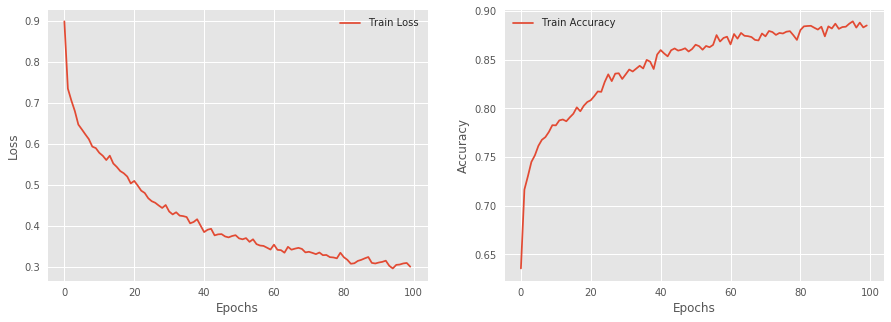

In [91]:
plot_loss_and_accuracy(history)

In [92]:
predictions = lstm_classif_v1.predict_classes(X_test)

print('Test Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))

print_plot_metrics('LSTMV1', Y_test, predictions)

Test Accuracy : 0.628

Classification Report : 
               precision    recall  f1-score   support

           0       0.24      0.28      0.26        18
           1       0.41      0.58      0.48        36
           2       0.78      0.75      0.76       138
           3       0.13      0.11      0.12        19
           4       0.73      0.64      0.68        77

    accuracy                           0.63       288
   macro avg       0.46      0.47      0.46       288
weighted avg       0.64      0.63      0.63       288

Confusion Matrix : 
 [[  5   8   2   2   1]
 [  3  21  10   1   1]
 [  3  17 104   4  10]
 [  3   2   6   2   6]
 [  7   3  12   6  49]]


## LSTM v2

In [93]:
lstm_classif_v2 = Sequential([
                LSTM(units=100, return_sequences= True, input_shape=(X_train.shape[1],X_train.shape[2])),
                LSTM(units=50, return_sequences=True),
                LSTM(units=30),
                Dense(Y_train_cat.shape[1], activation='softmax')
                ])

print(lstm_classif_v2.summary())

#plot_model(lstm_classif_v2, to_file=os.path.join(batch, 'lstm_classif2.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'lstm_classif2.png'))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 3, 100)            42400     
_________________________________________________________________
lstm_12 (LSTM)               (None, 3, 50)             30200     
_________________________________________________________________
lstm_13 (LSTM)               (None, 30)                9720      
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 155       
Total params: 82,475
Trainable params: 82,475
Non-trainable params: 0
_________________________________________________________________
None


In [94]:
lstm_classif_v2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = lstm_classif_v2.fit(X_train, Y_train_cat, epochs=100, batch_size=16, verbose=2, shuffle=False)

Epoch 1/100
342/342 - 2s - loss: 0.9817 - accuracy: 0.6090
Epoch 2/100
342/342 - 4s - loss: 0.7997 - accuracy: 0.6801
Epoch 3/100
342/342 - 3s - loss: 0.7457 - accuracy: 0.7131
Epoch 4/100
342/342 - 2s - loss: 0.7120 - accuracy: 0.7326
Epoch 5/100
342/342 - 2s - loss: 0.6726 - accuracy: 0.7511
Epoch 6/100
342/342 - 2s - loss: 0.6462 - accuracy: 0.7662
Epoch 7/100
342/342 - 2s - loss: 0.6367 - accuracy: 0.7647
Epoch 8/100
342/342 - 3s - loss: 0.6171 - accuracy: 0.7751
Epoch 9/100
342/342 - 3s - loss: 0.6173 - accuracy: 0.7731
Epoch 10/100
342/342 - 2s - loss: 0.5982 - accuracy: 0.7788
Epoch 11/100
342/342 - 2s - loss: 0.5924 - accuracy: 0.7797
Epoch 12/100
342/342 - 2s - loss: 0.5923 - accuracy: 0.7828
Epoch 13/100
342/342 - 2s - loss: 0.5578 - accuracy: 0.8013
Epoch 14/100
342/342 - 2s - loss: 0.5472 - accuracy: 0.7978
Epoch 15/100
342/342 - 2s - loss: 0.5426 - accuracy: 0.8059
Epoch 16/100
342/342 - 2s - loss: 0.5408 - accuracy: 0.7986
Epoch 17/100
342/342 - 1s - loss: 0.5319 - accura

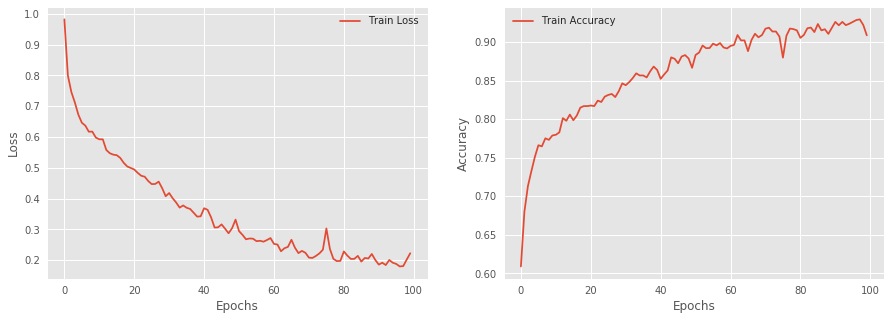

In [95]:
plot_loss_and_accuracy(history)

In [96]:
predictions = lstm_classif_v2.predict_classes(X_test)

print('Test Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))

print_plot_metrics('LSTMV2', Y_test, predictions)

Test Accuracy : 0.601

Classification Report : 
               precision    recall  f1-score   support

           0       0.16      0.28      0.20        18
           1       0.41      0.50      0.45        36
           2       0.76      0.74      0.75       138
           3       0.24      0.26      0.25        19
           4       0.77      0.56      0.65        77

    accuracy                           0.60       288
   macro avg       0.47      0.47      0.46       288
weighted avg       0.64      0.60      0.62       288

Confusion Matrix : 
 [[  5   5   5   1   2]
 [  3  18  14   0   1]
 [ 10  17 102   5   4]
 [  4   1   3   5   6]
 [ 10   3  11  10  43]]


## CNN LSTM

In [97]:
lstm_classif_v3 = Sequential([
    TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu'), input_shape=(None, X_train.shape[1], X_train.shape[2])),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(100, activation='relu'),
    Dense(Y_train_cat.shape[1], activation='softmax')
])


print(lstm_classif_v3.summary())

#plot_model(lstm_classif_v3, to_file=os.path.join(batch, 'lstm_classif3.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'lstm_classif3.png'))

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, None, 3, 32)       192       
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 1, 32)       0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 32)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 505       
Total params: 53,897
Trainable params: 53,897
Non-trainable params: 0
_________________________________________________________________
None


In [98]:
lstm_classif_v3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = lstm_classif_v3.fit(X_train.reshape(X_train.shape[0],1,X_train.shape[1], X_train.shape[2]), Y_train_cat, epochs=100, batch_size=16, verbose=2, shuffle=False)

Epoch 1/100
342/342 - 1s - loss: 2.4416 - accuracy: 0.5351
Epoch 2/100
342/342 - 0s - loss: 1.4222 - accuracy: 0.6112
Epoch 3/100
342/342 - 0s - loss: 1.2140 - accuracy: 0.5775
Epoch 4/100
342/342 - 0s - loss: 1.0232 - accuracy: 0.5869
Epoch 5/100
342/342 - 0s - loss: 0.9234 - accuracy: 0.6184
Epoch 6/100
342/342 - 0s - loss: 0.9291 - accuracy: 0.6371
Epoch 7/100
342/342 - 0s - loss: 0.8606 - accuracy: 0.6493
Epoch 8/100
342/342 - 0s - loss: 0.8483 - accuracy: 0.6578
Epoch 9/100
342/342 - 0s - loss: 0.8122 - accuracy: 0.6715
Epoch 10/100
342/342 - 0s - loss: 0.8222 - accuracy: 0.6691
Epoch 11/100
342/342 - 1s - loss: 0.8730 - accuracy: 0.6616
Epoch 12/100
342/342 - 0s - loss: 0.7769 - accuracy: 0.6968
Epoch 13/100
342/342 - 0s - loss: 0.7667 - accuracy: 0.6995
Epoch 14/100
342/342 - 0s - loss: 0.7619 - accuracy: 0.6969
Epoch 15/100
342/342 - 0s - loss: 0.7730 - accuracy: 0.6966
Epoch 16/100
342/342 - 0s - loss: 0.7570 - accuracy: 0.7096
Epoch 17/100
342/342 - 0s - loss: 0.7381 - accura

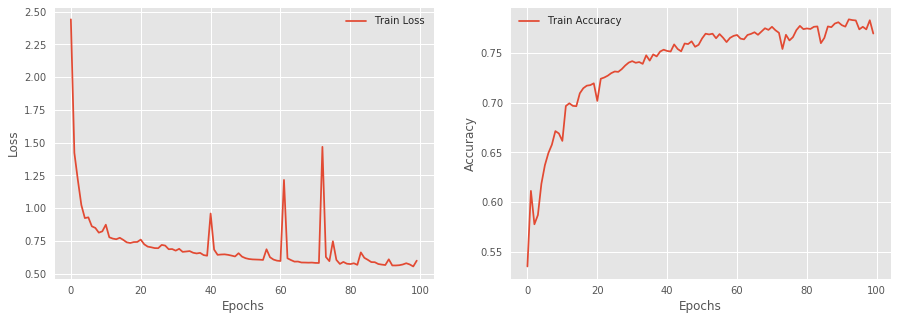

In [99]:
plot_loss_and_accuracy(history)

In [100]:
predictions = lstm_classif_v3.predict_classes(X_test.reshape(X_test.shape[0],1,X_test.shape[1], X_test.shape[2]))

print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

print_plot_metrics('CNN_LSTM', Y_test, predictions)

Accuracy : 0.427
Classification Report : 
               precision    recall  f1-score   support

           0       0.08      0.44      0.13        18
           1       0.36      0.33      0.35        36
           2       0.74      0.75      0.74       138
           3       0.00      0.00      0.00        19
           4       0.00      0.00      0.00        77

    accuracy                           0.43       288
   macro avg       0.24      0.30      0.24       288
weighted avg       0.41      0.43      0.41       288

Confusion Matrix : 
 [[  8   4   5   0   1]
 [  7  12  14   2   1]
 [ 17  15 103   1   2]
 [ 12   0   7   0   0]
 [ 60   2  10   5   0]]


## ConvLSTM

In [101]:
lstm_classif_v4 = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(1, 1, X_train.shape[1], X_train.shape[2])),
    Flatten(),
    Dense(Y_train_cat.shape[1], activation='softmax')
])


print(lstm_classif_v4.summary())

#plot_model(lstm_classif_v4, to_file=os.path.join(batch, 'lstm_classif4.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'lstm_classif4.png'))

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 2, 64)          35584     
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 645       
Total params: 36,229
Trainable params: 36,229
Non-trainable params: 0
_________________________________________________________________
None


In [102]:
lstm_classif_v4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = lstm_classif_v4.fit(X_train.reshape(X_train.shape[0],1, 1, X_train.shape[1], X_train.shape[2]), Y_train_cat, epochs=100, batch_size=16, verbose=2, shuffle=False)

Epoch 1/100
342/342 - 1s - loss: 2.8904 - accuracy: 0.5437
Epoch 2/100
342/342 - 1s - loss: 1.3218 - accuracy: 0.6548
Epoch 3/100
342/342 - 1s - loss: 1.0691 - accuracy: 0.6730
Epoch 4/100
342/342 - 0s - loss: 0.9758 - accuracy: 0.6914
Epoch 5/100
342/342 - 0s - loss: 0.8447 - accuracy: 0.7050
Epoch 6/100
342/342 - 0s - loss: 0.7835 - accuracy: 0.7195
Epoch 7/100
342/342 - 1s - loss: 0.7645 - accuracy: 0.7264
Epoch 8/100
342/342 - 0s - loss: 0.7387 - accuracy: 0.7233
Epoch 9/100
342/342 - 0s - loss: 0.7137 - accuracy: 0.7305
Epoch 10/100
342/342 - 1s - loss: 0.6996 - accuracy: 0.7354
Epoch 11/100
342/342 - 1s - loss: 0.7016 - accuracy: 0.7391
Epoch 12/100
342/342 - 1s - loss: 0.6769 - accuracy: 0.7435
Epoch 13/100
342/342 - 0s - loss: 0.6669 - accuracy: 0.7442
Epoch 14/100
342/342 - 0s - loss: 0.6669 - accuracy: 0.7438
Epoch 15/100
342/342 - 0s - loss: 0.6565 - accuracy: 0.7469
Epoch 16/100
342/342 - 1s - loss: 0.6665 - accuracy: 0.7418
Epoch 17/100
342/342 - 1s - loss: 0.6696 - accura

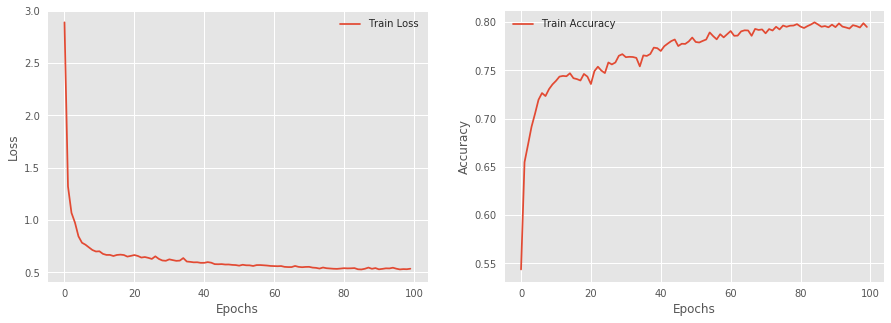

In [103]:
plot_loss_and_accuracy(history)

In [104]:
predictions = lstm_classif_v4.predict_classes(X_test.reshape(X_test.shape[0],1,1,X_test.shape[1], X_test.shape[2]))

print('Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))
print_plot_metrics('CONV_LSTM', Y_test, predictions)

Accuracy : 0.590

Classification Report : 
               precision    recall  f1-score   support

           0       0.24      0.33      0.28        18
           1       0.39      0.53      0.45        36
           2       0.81      0.72      0.76       138
           3       0.04      0.05      0.05        19
           4       0.65      0.58      0.62        77

    accuracy                           0.59       288
   macro avg       0.43      0.44      0.43       288
weighted avg       0.63      0.59      0.61       288

Confusion Matrix : 
 [[ 6  5  2  2  3]
 [ 7 19  8  1  1]
 [ 4 13 99 10 12]
 [ 4  3  3  1  8]
 [ 4  9 10  9 45]]


## XGB Classifier

In [105]:
X_new, Y_new = X[:-1], Y[1:] ## Lookback is 1 in case of XGB and Dense nets. It can only support that.

X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, 
                                                    train_size=0.95, 
                                                    shuffle=False,
                                                    )

print("Train/Test Sizes : ",X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

print("\nClass Distribution (Y_train) : ")
for cls in np.unique(Y_train):
    print("{} : {}".format(cls, Y_train.tolist().count(cls)))

print("\nClass Distribution (Y_test) : ")
for cls in np.unique(Y_test):
    print("{} : {}".format(cls, Y_test.tolist().count(cls)))

Y_train_cat, Y_test_cat = keras.utils.to_categorical(Y_train), keras.utils.to_categorical(Y_test)

Y_train_cat.shape, Y_test_cat.shape

Train/Test Sizes :  (5463, 5) (288, 5) (5463,) (288,)

Class Distribution (Y_train) : 
0 : 3157
1 : 1118
2 : 181
3 : 953
4 : 54

Class Distribution (Y_test) : 
0 : 18
1 : 36
2 : 138
3 : 19
4 : 77


((5463, 5), (288, 5))

In [106]:
xgb_classif = xgb.XGBClassifier(n_estimators=250, max_depth=2, objective="multi:softmax", num_class=5)

xgb_classif.fit(X_train, Y_train, verbose=10)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=0, num_class=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [107]:
predictions = xgb_classif.predict(X_test)

print('Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))
print_plot_metrics('XGBClassifier', Y_test, predictions)

Accuracy : 0.632

Classification Report : 
               precision    recall  f1-score   support

           0       0.18      0.39      0.25        18
           1       0.39      0.47      0.42        36
           2       0.79      0.80      0.80       138
           3       0.00      0.00      0.00        19
           4       0.87      0.61      0.72        77

    accuracy                           0.63       288
   macro avg       0.45      0.46      0.44       288
weighted avg       0.67      0.63      0.64       288

Confusion Matrix : 
 [[  7   6   2   3   0]
 [  9  17  10   0   0]
 [  8  15 111   3   1]
 [  5   2   6   0   6]
 [ 10   4  11   5  47]]


### LIME Interpretation

In [108]:
import random
random.seed(123)

j = random.randint(0, X_test.shape[0])

pred = xgb_classif.predict(X_test[j:j+1])[0]

print("Actual Value : {}".format(Y_test[j]))
print("Prediction   : {}\n".format(pred))


explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=dataset3.drop(columns=["Time", "hidden_state"]).columns,
                                                   #class_names=['Negative Return [-1]', "Positive Return [1]"],
                                                   training_labels=Y_train,
                                                   verbose=True,)

expXGB = explainer.explain_instance(X_test[j], 
                                    xgb_classif.predict_proba, 
                                    labels=[0,1,2,3,4],
                                    num_features=X_train.shape[0])

expXGB.show_in_notebook(show_table=True)

Actual Value : 2
Prediction   : 2

Intercept 0.5081250061662592
Prediction_local [0.22610405]
Right: 0.00056346145
Intercept 0.18289896037581127
Prediction_local [0.52420209]
Right: 0.4769885
Intercept 0.03995996313927254
Prediction_local [0.21964537]
Right: 0.52132225
Intercept 0.24782289297038956
Prediction_local [0.03486016]
Right: 0.0011250036
Intercept 0.021193177810391473
Prediction_local [-0.00481167]
Right: 7.5991017e-07


## XGB RF Classifier

In [109]:
xgb_rf_classif = xgb.XGBRFClassifier(n_estimators=250, max_depth=2, objective="multi:softmax", num_class=5)

xgb_rf_classif.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=10)

[0]	validation_0-merror:0.44097


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=0.8, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=1, max_delta_step=0, max_depth=2,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=250, n_jobs=0, num_class=5, num_parallel_tree=250,
                objective='multi:softprob', random_state=0, reg_alpha=0,
                reg_lambda=1e-05, scale_pos_weight=None, subsample=0.8,
                tree_method='exact', validate_parameters=1, verbosity=None)

In [110]:
predictions = xgb_rf_classif.predict(X_test)

print('Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))
print_plot_metrics('XGBClassifier', Y_test, predictions)

Accuracy : 0.559

Classification Report : 
               precision    recall  f1-score   support

           0       0.15      0.78      0.25        18
           1       0.39      0.36      0.38        36
           2       0.80      0.70      0.74       138
           3       0.00      0.00      0.00        19
           4       0.88      0.49      0.63        77

    accuracy                           0.56       288
   macro avg       0.45      0.47      0.40       288
weighted avg       0.68      0.56      0.59       288

Confusion Matrix : 
 [[14  2  2  0  0]
 [17 13  6  0  0]
 [25 16 96  0  1]
 [ 9  1  5  0  4]
 [27  1 11  0 38]]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.


### LIME Interpretation

In [111]:
import random
random.seed(123)

j = random.randint(0, X_test.shape[0])

pred = xgb_rf_classif.predict(X_test[j:j+1])[0]

print("Actual Value : {}".format(Y_test[j]))
print("Prediction   : {}\n".format(pred))


explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=dataset3.drop(columns=["Time", "hidden_state"]).columns,
                                                   #class_names=['Negative Return [-1]', "Positive Return [1]"],
                                                   training_labels=Y_train,
                                                   verbose=True,)

expXGB = explainer.explain_instance(X_test[j], 
                                    xgb_rf_classif.predict_proba, 
                                    labels=[0,1,2,3,4],
                                    num_features=X_train.shape[0])

expXGB.show_in_notebook(show_table=True)

Actual Value : 2
Prediction   : 2

Intercept 0.5163231520060247
Prediction_local [0.37539875]
Right: 0.16061762
Intercept 0.12879440630479705
Prediction_local [0.34250293]
Right: 0.28630647
Intercept 0.0850156289764575
Prediction_local [0.11903089]
Right: 0.38441253
Intercept 0.18688081107244178
Prediction_local [0.08133826]
Right: 0.08994424
Intercept 0.0829860005932448
Prediction_local [0.08172917]
Right: 0.07871917


## Dense Nets

In [112]:
dense_model1 = Sequential([ 
                     Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
                     #BatchNormalization(),      
                     Dropout(0.2),
                     Dense(64,  activation='relu'),
                     #BatchNormalization(),  
                     Dropout(0.2),
                     Dense(32,  activation='relu'),
                     #BatchNormalization(),
                     Dropout(0.2),
                     Dense(5,   activation='softmax')])

print(dense_model1.summary())
#plot_model(dense_model1, to_file=os.path.join(batch, 'dense1.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'dense1.png'))

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 128)               768       
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 5)               

In [113]:
dense_model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = dense_model1.fit(X_train, Y_train_cat, batch_size=16, epochs=100, verbose=1,shuffle=False, use_multiprocessing=True);

Epoch 1/100
342/342 [==============================] - 0s 1ms/step - loss: 5.2047 - accuracy: 0.4510
Epoch 2/100
342/342 [==============================] - 0s 939us/step - loss: 1.5814 - accuracy: 0.5459
Epoch 3/100
342/342 [==============================] - 0s 814us/step - loss: 1.2163 - accuracy: 0.5711
Epoch 4/100
342/342 [==============================] - 0s 1ms/step - loss: 1.1523 - accuracy: 0.5863
Epoch 5/100
342/342 [==============================] - 0s 1ms/step - loss: 1.0742 - accuracy: 0.5902
Epoch 6/100
342/342 [==============================] - 0s 1ms/step - loss: 0.9992 - accuracy: 0.6198
Epoch 7/100
342/342 [==============================] - 0s 1ms/step - loss: 0.9528 - accuracy: 0.6310
Epoch 8/100
342/342 [==============================] - 0s 911us/step - loss: 0.9274 - accuracy: 0.6376
Epoch 9/100
342/342 [==============================] - 0s 990us/step - loss: 0.8931 - accuracy: 0.6443
Epoch 10/100
342/342 [==============================] - 0s 1ms/step - loss: 0.8867 

342/342 [==============================] - 0s 758us/step - loss: 0.6321 - accuracy: 0.7650
Epoch 82/100
342/342 [==============================] - 0s 1ms/step - loss: 0.6284 - accuracy: 0.7686
Epoch 83/100
342/342 [==============================] - 0s 858us/step - loss: 0.6296 - accuracy: 0.7661
Epoch 84/100
342/342 [==============================] - 0s 882us/step - loss: 0.6270 - accuracy: 0.7683
Epoch 85/100
342/342 [==============================] - 0s 1ms/step - loss: 0.6355 - accuracy: 0.7604
Epoch 86/100
342/342 [==============================] - 0s 1ms/step - loss: 0.6261 - accuracy: 0.7701
Epoch 87/100
342/342 [==============================] - 0s 826us/step - loss: 0.6396 - accuracy: 0.7644
Epoch 88/100
342/342 [==============================] - 0s 998us/step - loss: 0.6246 - accuracy: 0.7635
Epoch 89/100
342/342 [==============================] - 0s 890us/step - loss: 0.6284 - accuracy: 0.7659
Epoch 90/100
342/342 [==============================] - 0s 786us/step - loss: 0.627

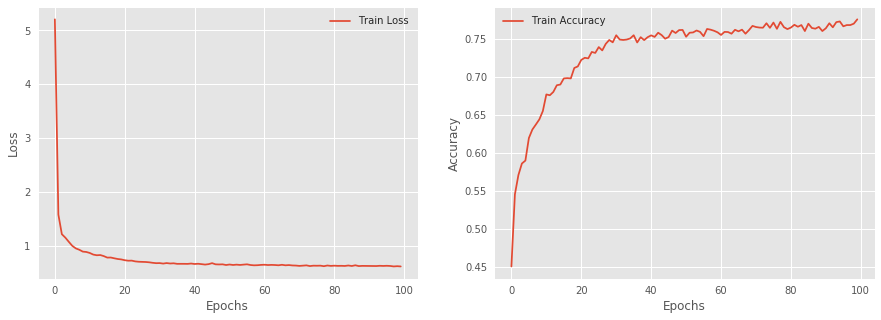

In [114]:
plot_loss_and_accuracy(history)

In [115]:
predictions = dense_model1.predict_classes(X_test)
print('Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))

print_plot_metrics('DenseNetv1', Y_test, predictions)

Accuracy : 0.628

Classification Report : 
               precision    recall  f1-score   support

           0       0.22      0.56      0.32        18
           1       0.47      0.53      0.50        36
           2       0.79      0.76      0.77       138
           3       0.14      0.05      0.08        19
           4       0.73      0.60      0.66        77

    accuracy                           0.63       288
   macro avg       0.47      0.50      0.47       288
weighted avg       0.66      0.63      0.63       288

Confusion Matrix : 
 [[ 10   4   2   1   1]
 [  7  19   8   2   0]
 [  8  15 105   0  10]
 [  6   0   6   1   6]
 [ 14   2  12   3  46]]


### LIME Interpretation

In [116]:
import random
random.seed(123)

j = random.randint(0, X_test.shape[0])

pred = dense_model1.predict_classes(X_test[j:j+1])[0]

print("Actual Value : {}".format(Y_test[j]))
print("Prediction   : {}\n".format(pred))


explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=dataset3.drop(columns=["Time", "hidden_state"]).columns,
                                                   #class_names=['Negative Return [-1]', "Positive Return [1]"],
                                                   training_labels=Y_train,
                                                   verbose=True,)

expXGB = explainer.explain_instance(X_test[j], 
                                    dense_model1.predict_proba, 
                                    labels=[0,1,2,3,4],
                                    num_features=X_train.shape[0])

expXGB.show_in_notebook(show_table=True)

Actual Value : 2
Prediction   : 2

Intercept 0.5936215402936287
Prediction_local [0.1989102]
Right: 3.2872808e-06
Intercept 0.14661967203039858
Prediction_local [0.47689206]
Right: 0.119834155
Intercept 0.04647504137979979
Prediction_local [0.24600856]
Right: 0.8787432
Intercept 0.189773007614776
Prediction_local [0.05627365]
Right: 0.00017403478
Intercept 0.02351073628634721
Prediction_local [0.02191553]
Right: 0.0012454197
